In [1]:
import requests
import random
import time
import numpy as np
import matplotlib.pyplot as plt

# Типы задач

Все задачи, выполняемые компьютером, можно разделить на две большие категории:
+ Задачи, сильно нагружающие процессор, занимающие большое количество его ресурсов. Такие задачи называются **CPU bound** (дословно - "связанные с CPU"). Эти задачи используют процессор на полную, а значит **скорость выполнения таких задач тем выше, чем выше "мощность" процессора**
+ Задачи, занимающиеся операциями ввода/вывода. Они называются **IO bound** (дословно - "связанные с вводом-выводом"). При выполнении таких задач процессор часто простаивает и ничего не делает, так как ожидает завершения операций ввода-вывода. Два наиболее ярких примера это **запросы в интернет** и **чтение с диска**. Данные из интернета в среднем поступают со скоростью 1-100 МБ/с, а с диска 10МБ-5ГБ/с. Для процессора эти скорости ОЧЕНЬ медленные. При поступлении новых данных он их очень быстро обрабатывает и начинает ждать следующей порции данных. То есть в промежутках между поступлениями порций данных процессор не делает ничего. Скорость выполнения таких задач ограничена скоростью поступления данных, это или скорость чтения/записи диска или скорость вашего интернета, процессор ничего не может с этим поделать.

## CPU bound задачи

Это задачи в которых узким местом по времени выполнения выступает производительность CPU. Как правило, их можно ускорить аппаратно за счёт повышения частоты процессора. Самый яркий пример &mdash; математические операции

В ячейке ниже приведён пример типичной CPU bound задачи - большое количество вычислений между целыми числами.

In [4]:
def do_work():
    for _ in range(10000000):
        random.randint(1, 40) ** random.randint(1, 20)

В Jupyter notebook есть множество "магических" модификаторов для ячеек, они начинаются с `%%` и пишутся в самой первой строке ячейки. Модификатор `%%time` позволит нам узнать время выполнения ячейки.

In [5]:
%%time


do_work()

CPU times: user 29.4 s, sys: 27.1 ms, total: 29.5 s
Wall time: 29.5 s


Разберём сообщение, генерируемое модификатором `%%time`:

Нас интересуют два числа:
+ CPU times - время работы процессора
+ Wall time - общее время выполнения кода

Они не обязательно равны друг другу, так как процессор в некоторые моменты выполнения программы может ничего не делать.

Мы видим, что общее время работы (Wall time) в данном случае равно времени работы процессора (CPU times). Это значит, что процессор был загружен всё время и не отдыхал ни в один момент времени.

## IO bound tasks

Это задачи в которых узким местом по времени выполнения выступают операции ввода-вывода. Это происходит из-за того, что чтение и запись данных происходит намного медленнее, чем их обработка, поэтому процессор длительное время простаивает, ожидая новой порции данных. Например, функция ниже делает указанное число запросов на главную страницу Google.

In [6]:
def n_requests(n):
    for _ in range(n):
        requests.get("https://google.com/")

In [7]:
%%time
n_requests(15)

CPU times: user 1.42 s, sys: 52.2 ms, total: 1.47 s
Wall time: 19.6 s


Мы видим, что 15 запросов суммарно заняли 9.95 секунд, в то время как процессор работал всего 446 мс. То есть около 5% всего времени, затраченного на запросы. Остальные 95% времени процессор ничего не делал.

То же самое верно и для одиночного запроса.

In [8]:
%%time
requests.get("https://google.com/")

CPU times: user 64.3 ms, sys: 16 ms, total: 80.3 ms
Wall time: 1.27 s


<Response [200]>

# Управление потоками в Python. Модуль threading

Для начала мы поговорим о реализации многопоточности. Мы уже говорили о том, что на одном ядре может параллельно исполняться 1-2 потока. К тому же в операционной системе существует планировщик задач, способный очень быстро переключать исполняющиеся потоки, создавая иллюзию параллельного выполнения сотен и тысяч потоков. В итоге мы приходим к логичному решению - ускорить наш код, разбив его инструкции на несколько потоков.

Модуль **threading** предоставляет API для управления потоками в Python.

In [9]:
import threading

Основной класс - **Thread**. Он принимает на вход функцию *target* (по своей сути это и есть набор инструкций для потока, но пока не проинтерпретированных) и аргументы *args* к этой функции. Соответственно каждый поток будет исполнять данную функцию с переданными аргументами. 

Полученный объект класса **Thread** имеет 2 основных метода: **start** и **join**. `start` запускает исполнение потока, а `join` указывает интерпретатору, что надо подождать пока поток не закончит исполнение.

## Использование threading для ускорения IO bound задач

In [12]:
def parallel_requests(num_requests, n_threads):
    threads = [threading.Thread(target=n_requests, args=(num_requests // n_threads,)) for _ in range(n_threads)]
    for thread in threads:
        thread.start()
        
    for thread in threads:
        thread.join()        

Функция выше принимает на вход количество запросов, которые нужно сделать, а также число потоков на которые требуется распараллелить запросы. Каждый поток, представляет из себя объект класса `Thread`. В функции мы создаём `n_threads` таких потоков в списке, и каждому потоку даём по `num_requests // n_threads` запросов, т.е. делим их поровну между потоками. Функция `n_requests`, описанная нами ещё выше будет представлять из себя непосредственно инструкции для потока (определённое количество запросов в интернет)

In [14]:
%%time

n_requests(15)    # 15 запросов в одном потоке

CPU times: user 1.24 s, sys: 72.7 ms, total: 1.31 s
Wall time: 20.1 s


In [15]:
%%time

parallel_requests(15, 15)    # 15 запросов в 15 потоках (по одному запросу на поток)

CPU times: user 1.01 s, sys: 59.7 ms, total: 1.07 s
Wall time: 1.57 s


В результате имеем прирост к скорости выполнения приблизительно в 10 раз, относительно того же количества запросов в одном потоке. В вызове выше произошло разделение 15 запросов на 15 потоков (то есть по одному запросу на поток).

Также заметим, что теперь время работы CPU составляет около **25%** от общего время работы, что очень хорошо. Это значит, что мы смогли более эффективно использовать процессорное время и он меньше простаивал.

### Метод `join`

Но всё ещё может быть не совсем понятно, зачем нужен метод `join`. Посмотрим на примере:

In [17]:
def random_sleep():
    sleep_time = random.randint(1, 10)
    time.sleep(sleep_time)
    print(sleep_time)

Функция `time.sleep` тоже является IO bound задачей, так как мы принудительно заставляем процессор ничего не делать. Это очень похоже на состояние, когда мы читаем с диска или из интернета, только в случае `time.sleep` потребляется совсем ничтожное количество ресурсов процессора. В примере ниже процессор был загружен 0.03% от всего времени.

In [18]:
%%time
time.sleep(10)

CPU times: user 3.42 ms, sys: 0 ns, total: 3.42 ms
Wall time: 10 s


Вернёмся к `join`. Запустим 10 потоков, каждый из которых будет спать случайное время, а затем сразу запустим следующую ячейку, не дожидаясь исполнения предыдущей.

In [21]:
threads = [threading.Thread(target=random_sleep) for _ in range(10)]
for thread in threads:
    thread.start()
for thread in threads:    
    thread.join()

3
4
4
6
6
7
8
9
9
10


In [22]:
print("Something")

Something


Мы видим, что исполнение ячейки `print("Something")` не началось, пока не завершилось исполнение всех потоков в ячейке выше. Этого не происходит из-за `join`.

Теперь попробуем сделать тоже самое, но без использования `join`

In [23]:
threads = [threading.Thread(target=random_sleep) for _ in range(10)]
for thread in threads:
    thread.start()

1


In [24]:
print("Thread has not finished yet!")

Thread has not finished yet!
5
5
7
8
9
9
9
9
10


В этом случае исполнение следующей ячейки началось сразу же, без ожидания выполнения всех потоков. К тому же печать "Thread has not finished yet!" завершилась раньше любого из них.

Всё это, конечно, здорово, но всё равно не совсем понятно, как и зачем это использовать.

Зачастую мы хотим распараллелить только часть задачи, которую нам нужно сделать. Например, мы параллельно скачиваем данные с 100 различных сайтов, а сразу после этого хотим их как-то обработать. Чтобы исполнение нашего кода не ушло к стадии обработки данных не дождавшись завершения их скачивания (почти как в примере выше) и нужен `join`. Для наглядной иллюстрации запустим скрипт **threading_join_demo.py**. Давайте представим, что `download_data` - это какая-то IO bound задача, например скачивание таблиц с интернета, а `process_data` как-то обрабатывает эти данные. Запустив скрипт, мы увидим, что он всё равно не завершится пока все потоки не "скачают данные", однако их "обработка" произойдёт намного раньше их полного скачивания, что крайне нежелательно. Поэтому мы и используем `join`, мы не хотим, чтобы после запуска потоков выполнение программы убегало вперёд не дождавшись их.

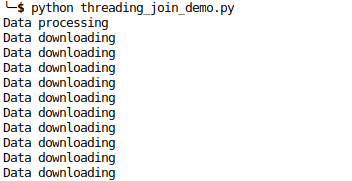

Заодно мы можем посмотреть как запуск этого скрипта выглядит в **htop**.

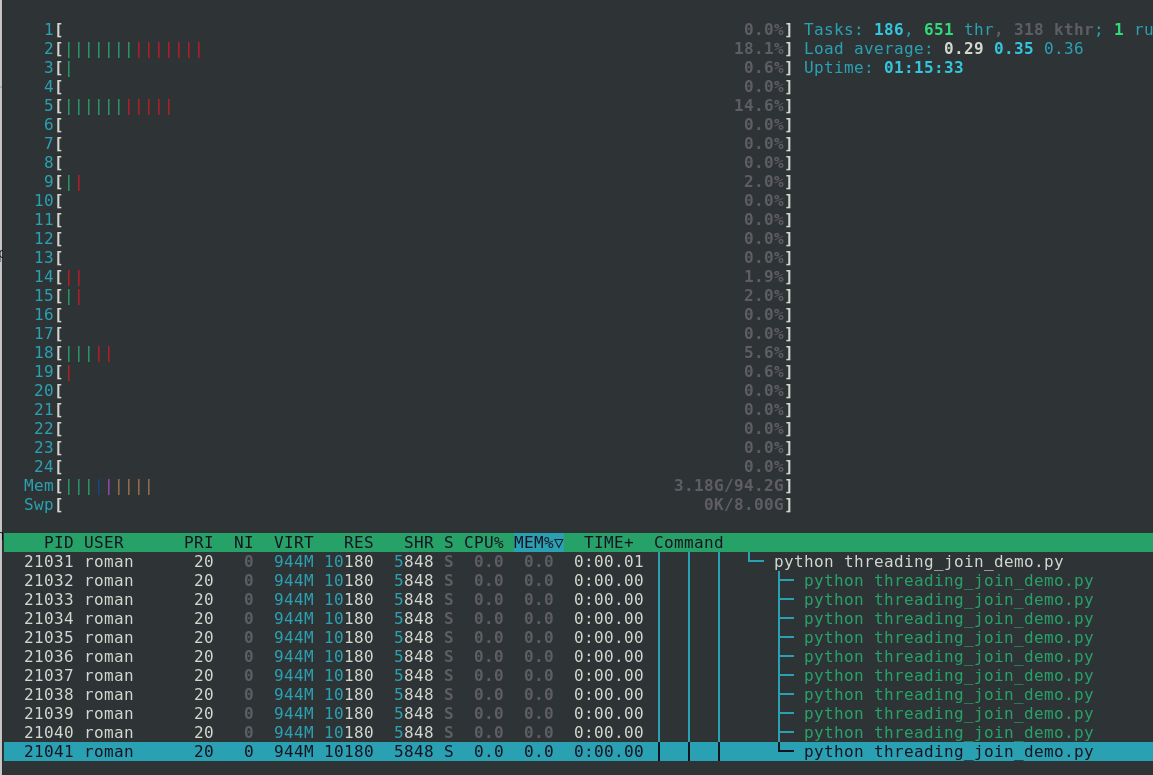

Обратите внимание на колонку *command*. Мы видим один **процесс** нашей программы, он выделен белым цветом и 10 зелёных **потоков**, каждый из которых спит и ничего не делает (колонка *S*), так как они заняты IO bound задачей. 

На самом деле потоков здесь 11. Один из них прячется за белыми буквами, так как изначально каждый процесс имеет один главный поток. В нём как раз и происходит выполнение всего основного кода программы: создание списка потоков, запуск списка потоков, выполнение функции `process_data`

### Ограничения threading

Потоки являются довольно легковесными, они требуют мало памяти и их можно создать довольно много. На картинке видно, что кратное увеличение количества потоков приводит к **практически** кратному уменьшению времени необходимому для совершения запросов. Слово **практически** здесь выделено не случайно, дело в том, что когда потоков становится очень много, затраты процессорного времени на их создание и постоянное переключение тоже становятся очень большими, поэтому эффективность постепенно снижается. Если бы этих затрат не было, то 100 запросов в 100 потоках на картинке снизу (фиолетовая линия) исполнялись бы за 0.6 секунд, а не за 4 как на картинке.

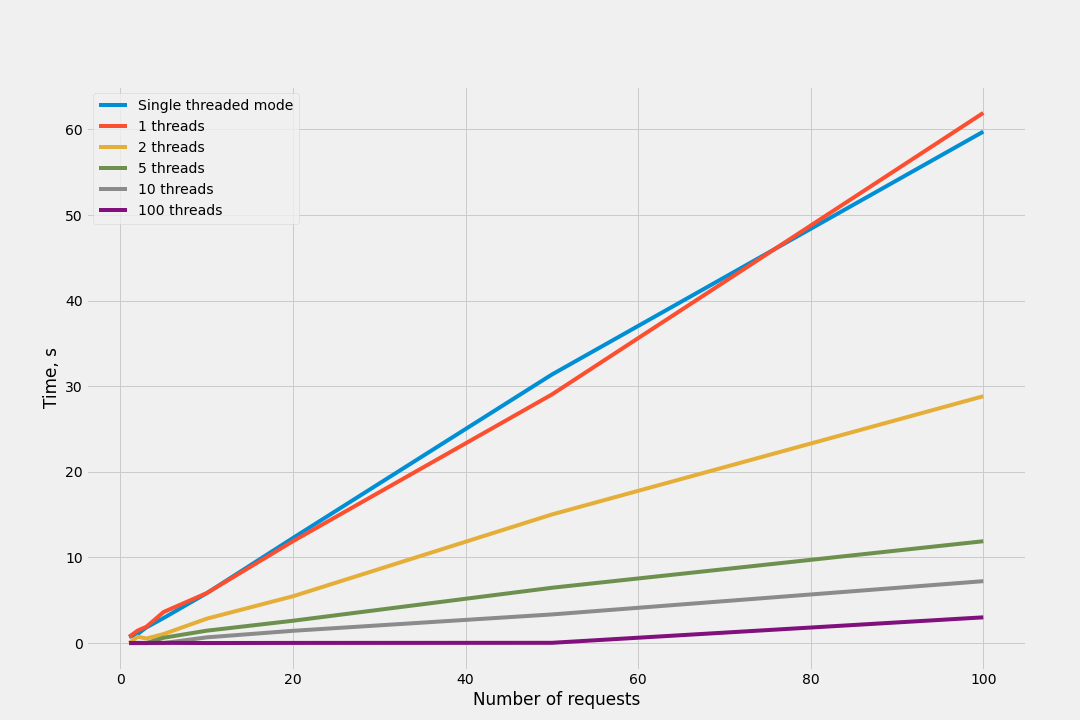

# Продолжаем работать с threading

## 3 способа использовать threading

### Самый простой

Наиболее простой и безболезненный способ сделать многопоточность. Плюс в том, что можно совершенно не забивать голову тем, как это работает, но если что-то пойдёт не так, то не понятно что делать.

На этот раз нужный класс лежит в другом модуле. Модуль `concurrent.futures` предоставляет нам удобные функции для высокоуровнего использования параллельного программирования (он тоже входит в стандартную библиоеку питона).

In [26]:
from concurrent.futures import ThreadPoolExecutor
import requests
from threading import Thread
import time

In [30]:
%%time

n_requests = 100
n_threads = 50

with ThreadPoolExecutor(n_threads) as pool:                                 # Создаём пул с заданным числом потоков
    results = pool.map(requests.get, ["https://google.com/"] * n_requests)  # Применяем функцию к контейнеру с аргументами для этой функции 
    print(type(results), list(results)[:5])                                 # Получаем результаты исполнения функций из генератора results

<class 'generator'> [<Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>]
CPU times: user 5.29 s, sys: 454 ms, total: 5.74 s
Wall time: 3.46 s


Класс `ThreadPoolExecutor` создаёт специальный объект &mdash; контекстный менеджер. Этот тип объектов умеет работать с конструкциями `with`, как в случае файлов. `open("some_file.txt")` тоже возвращает контекстный менеджер. При создании этого объекта мы должны указать число потоков, которые мы используем. У данного объекта есть метод `map`, он принимает функцию, которая должна исполняться внутри потока, а также список **всех** данных, которые нужно обработать.

При вызове `map` происходит магия. `pool` берёт и создаёт количество потоков, которое мы указали и равномерно распределяет данные по потокам. То есть нам совершенно не нужно беспокоиться о том, как передавать данные в поток. Нам всего-лишь нужна функция, которая что-то делает с данными (`requests.get` в примере) и сами данные для этой функции (100 адресов гугла). Всё распределится "само" и выполнится максимально эффективно. При этом нам ещё вернутся результаты в виде итератора.

### Чуть сложнее

Здесь потребуются знания базового интерфейса модуля `threading`, по скорости - то же самое, что и `ThreadPoolExecutor`. Плюсы в том, что позволяет более гибко настраивать поток, удобнее передавать аргументы, по-желанию можно не делать `join`, который в `ThreadPoolExecutor` делается автоматически. Минус - чуть больше букв (5 строк на самый базовый случай), а также придётся самим заниматься распределением аргументов по потокам

In [11]:
import threading

In [9]:
%%time
def make_requests(url_list):
    for url in url_list:
        requests.get(url)

# Выполняем такую-же задачу, как и в предыдущем пункте
        
n_requests = 100
n_threads = 50
threads = [threading.Thread(target=make_requests, args=(["https://google.com/"] * (n_requests // n_threads),)) for _ in range(n_threads)]
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()     

CPU times: user 1.49 s, sys: 127 ms, total: 1.62 s
Wall time: 2.42 s


### Сложно

Создание собственного класса-наследника `Thread`. Здесь от нас требуется переопределить метод `run` - это код, который будет исполняться в потоке. По желанию, можно дописать конструктор и любые другие методы. Плюс - супер гибкая настройка потока, минус - ещё больше букв, хотя интерфейс простой и запутаться здесь сложно. По скорости опять таки без изменений.

In [7]:
%%time

class MyThread(threading.Thread):
    def __init__(self, url_pool):
        super().__init__()    # Нужно сначала инициализировать объект конструктором родительского класса
        self.url_pool = url_pool
    
    def run(self):
        for url in self.url_pool:
            requests.get(url)
            
            
n_requests = 100
n_threads = 50
    
threads = [MyThread(["https://google.com/"] * (n_requests // n_threads)) for _ in range(n_threads)]
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()     

CPU times: user 2.57 s, sys: 281 ms, total: 2.85 s
Wall time: 2.26 s


С классом мы можем делать что угодно: например, добавлять новые методы и атрибуты, но главное не забыть:

+ Отнаследоваться от класса `Thread`
+ Сделать `super().__init__()` в конструкторе
+ Переопределить метод `run`

Метод `run` не принимает аргументов, поэтому если мы захотим передать данные в поток, то дожны будем сделать это через конструктор, сохранив их в атрибуты. Содержимое метода `run` непосредственно является инструкциями потока. Там мы пишем абсолютно любой код, который мы хотим распараллелить

## Пример применения многопоточности НЕ в запросах к интернету

Пока что мы говорили только про применение многопоточности в IO bound задачах. Но прежде чем перейти к CPU bound, давайте рассмотрим ещё один пример использования многопоточности. Для этого сформулируем задачу:

**Задача:** Раз в секунду программа в бесконечном цикле печатает число 0. При нажатии на любую кнопку программа продолжает печатать, но уже нажатый символ. Между событиями печати не должно проходить более 1 секунды.

Наивное решение, которое первое приходит на ум:

In [8]:
character = "0"
while True:
    print(character)
    time.sleep(1)
    character = input()

0


 1


1


 2


2


KeyboardInterrupt: Interrupted by user

`input` блокирует основной поток программы, то есть прерывает её исполнение до поступления данных. Это ещё один пример IO bound задачи, процессор ничего не делает пока ждёт ввода от пользователя. Кажется нам понадобится сторонняя библиотека (см. скрипты **threading_use_case_base.py**, **threading_use_case_full.py**, так как на линуксе библиотеке нужны права администратора, то надо запускать из терминала). Но также приведу код здесь, но не факт, что он будет работать.

In [31]:
import keyboard

ModuleNotFoundError: No module named 'keyboard'

In [12]:
# Код из скрипта threading_use_case_base.py

character = 0
while True:
    print(character)
    time.sleep(1)
    character = keyboard.read_key()

0


ImportError: You must be root to use this library on linux.

Такой способ уже имеет одно заметное приемущество &mdash; нам не нужно нажимать на **Enter** чтобы ввести символ, однако выполнение программы по прежнему блокируется. Но не спешите расстраиваться! Ведь когда мы делаем запрос в интернет наша программа тоже блокируется и ничего не делает, только это происходит гораздо быстрее. По сути обе ситуации являются типичными IO bound задачами, а значит мы можем использовать многопоточность.

In [14]:
# Код из скрипта threading_use_case_full.py


class KeyboardListener(threading.Thread):
    def __init__(self, active_character):
        super().__init__()
        self.active_character = active_character

    def run(self):
        while True:
            self.active_character = keyboard.read_key()
            if self.active_character == "esc":
                return


character = "0"
listener = KeyboardListener(character)
listener.start()
while True:
    print(character)
    time.sleep(1)
    character = listener.active_character

Exception in thread Thread-158:
Traceback (most recent call last):
  File "/home/roman/anaconda3/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/tmp/ipykernel_40123/3826479094.py", line 8, in run
  File "/home/roman/anaconda3/lib/python3.9/site-packages/keyboard/__init__.py", line 935, in read_key
    event = read_event(suppress)
  File "/home/roman/anaconda3/lib/python3.9/site-packages/keyboard/__init__.py", line 924, in read_event
    hooked = hook(queue.put, suppress=suppress)
  File "/home/roman/anaconda3/lib/python3.9/site-packages/keyboard/__init__.py", line 461, in hook
    append(callback)
  File "/home/roman/anaconda3/lib/python3.9/site-packages/keyboard/_generic.py", line 67, in add_handler
    self.start_if_necessary()
  File "/home/roman/anaconda3/lib/python3.9/site-packages/keyboard/_generic.py", line 35, in start_if_necessary
    self.init()
  File "/home/roman/anaconda3/lib/python3.9/site-packages/keyboard/__init__.py", line 196, in ini

0
0
0
0
0
0
0


KeyboardInterrupt: 

Код выше решает поставленную нами ранее задачу. Давайте разберёмся как он работает.
Вся суть в том, что мы полностью принимаем тот факт, что мы **не можем** передать программе информацию о нажатии кнопки без блокировки её исполнения. Однако, что если функционал детекции нажатых нами кнопок мы переложим на отдельный поток? Таким образом основной поток не будет прерываться и будет каждую секунду печатать число, а поток для детекции будет постоянно заблокированным до нажатия на кнопку.

Теперь конкретно разберём пример. Класс `KeyboardListener` будет создавать поток, который в бесконечном цикле как бы "прослушивает" нажатия кнопок на клавиатуре и сохраняет последнюю нажатую кнопку в атрибут `active_number`. При этом большую часть времени он заблокирован и ждёт нажатия.

Мы создаём объект потока в главном потоке программы и запускаем его. Очень важно отметить, что здесь мы не используем `join`, так как мы не хотим ждать пока этот поток завершится, мы хотим сразу продолжить выполнять программу дальше.

При этом на каждой итерации цикла по печати текущего числа мы "подсматриваем" его у потока, обращаясь к его атрибуту `number = listener.active_number`.

## Доступ к данным при многопоточности

До сих пор мы использовали потоки только для того, чтобы распараллеливать задачи и даже не задумывались от том, что зачастую нам нужно получть данные, которые были получены в потоке. Например, в случае с интернет запросами, мы хотим получать статус запроса, его содержимое и так далее. Но как нам вернуть эти данные их потока? И возможно ли это вообще?

Краткий ответ - ДА. Мы уже видели, что при использовании `ThreadPoolExecutor` мы можем получить в распоряжение генератор с результатами. Однако остаётся вопрос &mdash; как это работает?

Поскольку потоки принадлежат одному процессу, они все имеют общую память, которой обладает процесс (та самая **virtual memory**). Любой поток может производить операции с этой памятью. Например, потоки могут добавлять элементы в список, объявленый в глобальной области видимости, но несколько удобнее обмениваться данными через атрибуты объекта потока (как в примере выше).

Для того, чтобы убедиться в том, что все потоки имеют доступ ко всей памяти процесса, разберём игрушечный пример. Мы запустим 3 потока, каждый из которых будет спать случайное время и записывать число в список из главного потока.

In [32]:
import random

In [43]:
lst = []

def append_to_list(thread_id):
    time.sleep(random.randint(1, 5))
    lst.append(thread_id)

threads = [threading.Thread(target=append_to_list, args=(i,)) for i in range(3)]
for thread in threads:
    thread.start()

In [46]:
lst

[1, 2, 1]

Получилось! В списке есть 3 числа, значит все потоки смогли добавить туда по одному элементу. Получается, что потоки могут обмениваться данными друг с другом.

### А что если попробовать получить доступ к данным одновременно?

Попытаемся изменить первый элемент списка *lst* сразу 10 потоками. Как вы думаете, что же произойдёт?

In [47]:
lst = [0, 0, 0]

def append_to_list(thread_id):
    time.sleep(1)
    lst[0] = thread_id

threads = [threading.Thread(target=append_to_list, args=(i,)) for i in range(10)]
for thread in threads:
    thread.start()

In [49]:
lst

[6, 0, 0]

### Ничего. Но как тогда потоки решили, кто именно из них в итоге запишет число?

Ладно. Я долго скрывал это от вас, но пришло время раскрыть все карты...

**Потоки в питоне НЕ выполняются параллельно!**

Но как же так? Мы же видели, что увеличение количества потоков позволяет в десятки и сотни раз повысить скорость выполнения серии запросов в интернет. А также детектировать нажатия на клавиатуру пока работает основной поток. Давайте разбираться, как это работает

# Во всём "виноват" GIL

Начнём издалека. Дело в том, что операции одновременного доступа к данным, которые мы пытались совершить в предыдущем примере крайне небезопасны и могут привести к неопределённым последствиям и повреждению данных. Вследствие этого в питоне предусмотрено специальное средство, обеспечивающее безопасность обращения потоков к общим данным - **Global Interpreter Lock** (**GIL**). Разные языки по разному борются с этой проблемой, однако зачастую позволяют исполнять потоки одного процесса по-настоящему **параллельно**.

В питоне решили поступить более радикально, **запретив** исполнять более одного потока **одновременно** на уровне интерпретатора для обеспечения потокобезопасности. **Таким образом *многопоточность* в питоне выглядит практически полностью аналогично *многозадачности* на одноядерных CPU**.

То есть, если мы имеем 100 потоков, то интерпретатор будет переодически переключать их между собой, создавая *иллюзию* параллельного выполнения.

В случае добавления элементов в список несколькими потоками интерпретатор **гарантирует**, что это произойдёт последовательно, поскольку в каждый момент времени работает только один поток. Когда поток приступает к работе и выполняет CPU bound задачу GIL переходит в закрытое состояние (**acquire**). В данном состоянии GILa ни один поток кроме данного не может выполняться и переключения потоков тоже не может произойти. Интерпретатор питона не может переключать потоки во время выполнения CPU bound задачи, так как это может нарушить нормальный ход её выполнения. Когда в потоке начинается I/O часть, GIL открывается (**release**) и интерпретатор может выбрать новый поток для выполнения, пока первый занят I/O задачей, интерпретатор же сразу закрывает GIL и так пока всё не закончится.

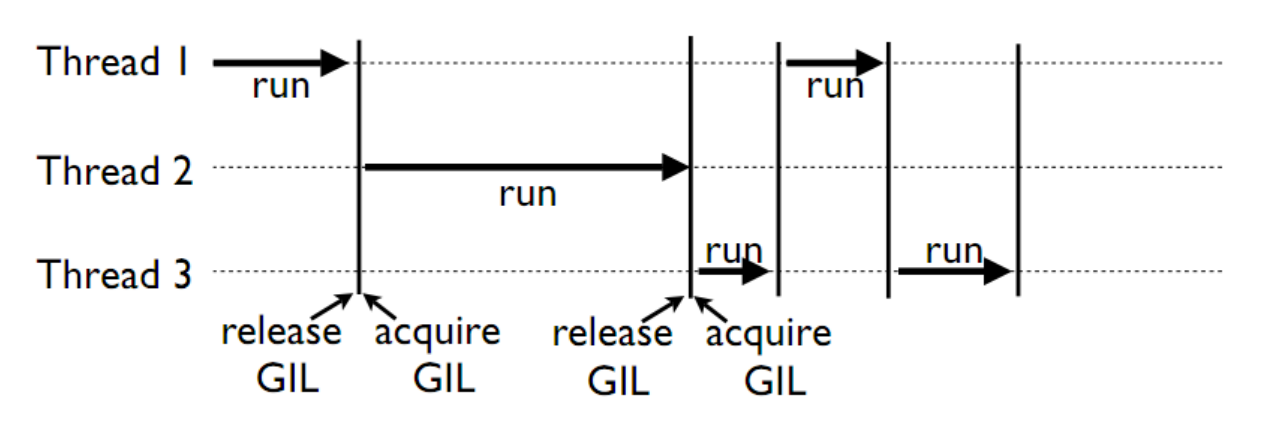

Это очень сложный механизм и, если пока ничего не понятно, то это совсем не страшно. Главное, что нужно запомнить &mdash; **потоки в питоне исполняются последовательно, а не параллельно, аналогично *многозадачности* на одноядерных CPU**

Из вышеперечисленного следует, что потоки не могут решать CPU bound задачи, так как **они работают только последовательно**. Докажем это на примере.

In [50]:
def do_work(dummy=None):
    for _ in range(1000000):
        random.randint(1, 40) ** random.randint(1, 20)

Мы сделали точно такую же функцию `do_work`, как в начале предыдущей лекции. Она иллюстрирует типичную CPU bound задачу &mdash; математические вычисления. К тому же мы добавили ей один аргумент, который не нужен для расчётов, но пригодится для вызова функции.

Измерим время выполнения функции

In [51]:
%%time

do_work()

CPU times: user 4.09 s, sys: 23.5 ms, total: 4.11 s
Wall time: 4.12 s


А теперь посмотрим, какое время займёт последовательное выполнение этой функции 10 раз

In [52]:
%%time

for _ in range(10):
    do_work()

CPU times: user 29.4 s, sys: 20.2 ms, total: 29.4 s
Wall time: 29.4 s


Ровно в 10 раз больше, всё логично.

Теперь попробуем запустить эту функцию 10 раз в 10 потоках (то есть по одной на поток). Сделаем мы это при помощи `ThreadPoolExecutor`. Для этого нам и нужен был бесполезный аргумент в `do_work`. Для использования в `ThreadPoolExecutor` наша функция обязательно должна принимать хотя бы один аргумент.

In [53]:
%%time

with ThreadPoolExecutor(10) as pool:
    pool.map(do_work, [None for _ in range(10)])

CPU times: user 34.8 s, sys: 550 ms, total: 35.4 s
Wall time: 35.3 s


И всё отработало даже хуже, чем при последовательном исполнении. Как мы видим, потоки совершенно не справляются с ускорением IO bound задач

Поскольку функция **do_work** не имеет никакого I/O, GIL не будет отпускать данные потоки на протяжении всего выполнения. Это значит, что их переключение будет происходить крайне редко. Это будет приводить к сильным задержкам в исполнении инструкций других потоков. С увеличением числа потоков время ожидания сильно увеличивается.

Для демонстрации того, что одновременно в питоне работает только один поток, запустим скрипт **GIL_demo.py** (код ниже) и **htop**.

In [54]:
# Код из скрипта GIL_demo.py


def do_work():
    for _ in range(100000000):
        random.randint(1, 40) ** random.randint(1, 20)


threads = [threading.Thread(target=do_work) for i in range(2)]    # Всего мы имеем 3 потока, 2 созданных + 1 главный
for thread in threads:
    thread.start()

do_work()

KeyboardInterrupt: 

Вспоминаем, что колонка *S* показывает статус процесса/потока: *R* - активен, *S* - бездействует.

Мы видим, что в любой момент времени, активен только один поток, в то время как оставшиеся два - спят. Эти картинки наглядно демонстрируют эффект от работы GIL.

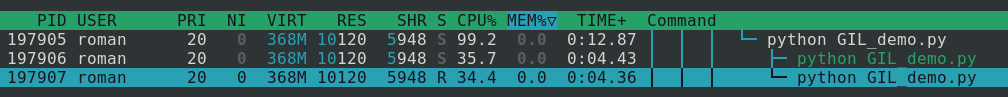
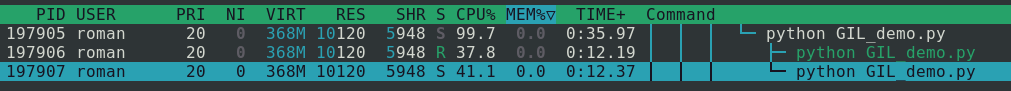
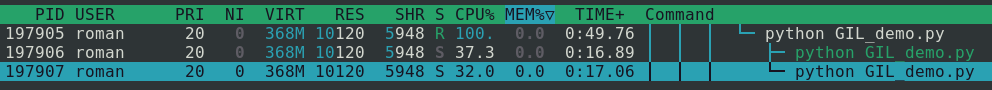

Но почему же тогда IO bound задачи ускорялись, если потоки исполняются последовательно? 

По сути там происходит параллельное **ожидание**. Если в момент, когда у нас началось ожидание (например, интернет запрос на 2 секунды), потоки переключатся, то мы сразу же получаем приемущество, поскольку в новом потоке мы делаем что-то полезное, а в потоке, который мы оставили по прежнему идут эти 2 секунды, которые нам нужно было подождать.

То есть в случае многопоточности в питоне, мы распараллеливаем не полезные вычисления, а ожидание.

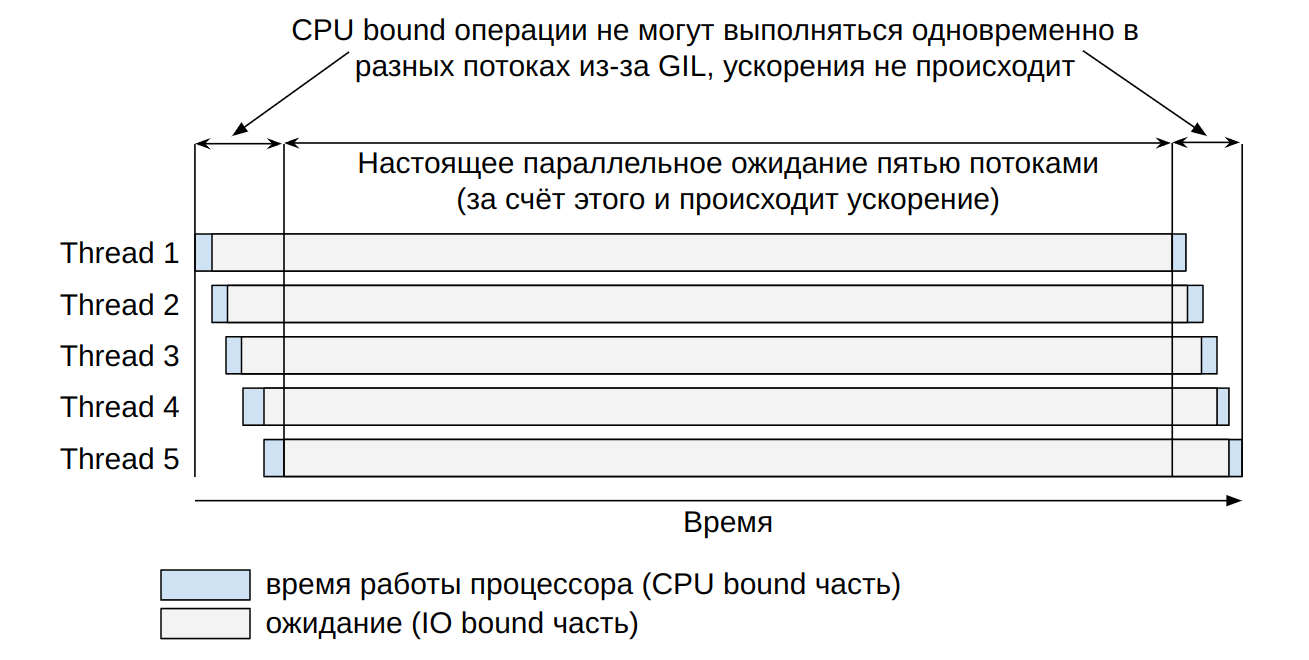

## Итоги по threading

**Когда стоит использовать:**
+ Параллельные интернет запросы
+ Неблокирующий ввод-вывод (задача с нажатием кнопок)
+ Запараллеливание любого достаточно медленного I/O

**Плюсы:**
+ Легковесные (но лучше не запускать больше 1000, расходы на их переключение в один момент начинают быть слишком большими)
+ Можно использовать общую память

**Минусы:**
+ Нет настоящей параллельности из-за GIL (в интернете все пишут, что это очень не круто, но он реально избавляет от кучи головной боли с синхронизацией потоков)
+ Совсем не могут в CPU bound задачи из-за первого минуса

# Multiprocessing

Название говорит само за себя, вместо использования множества потоков, здесь используется множество процессов. В Python многопроцессорность реализуется модулем `multiprocessing` стандартной библиотеки. Его основной интерфейс полностью повторяет интерфейс `threading`, поэтому про него здесь говорить не будем. Так же как и в `threading` здесь есть базовый класс `Process` с методами `start` и `join`, всё по аналогии.

Ниже приведены 3 способа использовать `multiprocessing` по аналогии с `threading`, убедитесь, что они очень похожи.

### Самый простой

In [1]:
from concurrent.futures import ProcessPoolExecutor

In [23]:
%%time

n_requests = 10
n_proc = 10

with ProcessPoolExecutor(n_proc) as pool:                               
    results = pool.map(requests.get, ["https://google.com/"] * n_requests)
    print(type(results), list(results)[:5])                                 

<class 'generator'> [<Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>]
CPU times: user 10.3 ms, sys: 44.9 ms, total: 55.3 ms
Wall time: 509 ms


### Чуть сложнее

In [ ]:
import multiprocessing

In [ ]:
%%time

def make_requests(url_list):
    for url in url_list:
        requests.get(url)

        
n_requests = 10
n_proc = 10
processes = [multiprocessing.Process(target=make_requests, args=(["https://google.com/"] * (n_requests // n_proc),)) for _ in range(n_proc)]
for proc in processes:
    proc.start()
for proc in processes:
    proc.join()     

### Сложно

In [ ]:
%%time

class MyProcess(multiprocessing.Process):
    def __init__(self, url_pool):
        super().__init__()
        self.url_pool = url_pool
    
    def run(self):
        for url in self.url_pool:
            requests.get(url)
            
            
n_requests = 10
n_proc = 10
    
processes = [MyProcess(["https://google.com/"] * (n_requests // n_proc)) for _ in range(n_proc)]
for proc in processes:
    proc.start()
for proc in processes:
    proc.join()     

In [ ]:
%%time

for _ in range(10):
    requests.get("https://google.com/")

Как вы видите, всё идентично, кроме названий классов. К тому же мы заодно убедились в том, что процессы успешно справляются с ускорением IO bound задач (запросов в интернет)

Как мы уже видели, потоки не справляются с CPU bound задачами.

In [ ]:
def do_work():
    for _ in range(1000000):
        random.randint(1, 40) ** random.randint(1, 20)

In [ ]:
%%time
do_work()      # Один поток

In [ ]:
%%time
n_threads = 2

threads = [threading.Thread(target=do_work) for _ in range(n_threads)]      # Два потока
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()     

Попробуем сделать тоже самое на процессах. Создадим 2 процесса, которые выпоняют CPU bound вычисления в `do_work` и заодно посмотрим сколько времени занимает один вызов этой функции

In [ ]:
%%time

do_work()

In [ ]:
%%time
n_proc = 2
procs = [multiprocessing.Process(target=do_work) for _ in range(n_proc)]
for proc in procs:
    proc.start()
for proc in procs:
    proc.join()     

Два процесса выполнились **параллельно** за то же самое время, что и один. Почему же так произошло? В чём различия с `threading`?

Мы знаем, что процесс это набор инструкций, хранящихся в памяти и процесс их исполнения. Изначально программа на питоне представлена всего одним процессом, он создаётся в момент запуска интерпретатора. То есть для создания процесса нужно просто запустить новую копию интерпретатора. Это помогает нам избавиться от проблемы GIL. Нет, он никуда не исчезнет, наоборот, теперь в каждом из созданных процессов будет свой GIL, блокирующий параллельное исполнение потоков (кстати, в созданных процессах можно также создавать потоки и процессы). Однако поскольку сами процессы представляют из себя отдельный запуск интерпретатора, они являются полностью изолированными друг от друга. Они НЕ имеют общей памяти, а GIL процесса может воздействовать только на внутренние потоки, но никак не на другие процессы.

Суммируя всё сказанное выше, ничто не мешает отдельным питоновским процессам исполняться параллельно на разных ядрах CPU, поскольку GIL имеет власть только внутри одного процесса.

Полностью аналогичного эффекта можно достичь запустив ваш скрипт несколько раз на разных наборах данных прямо из терминала, но это не удобно.

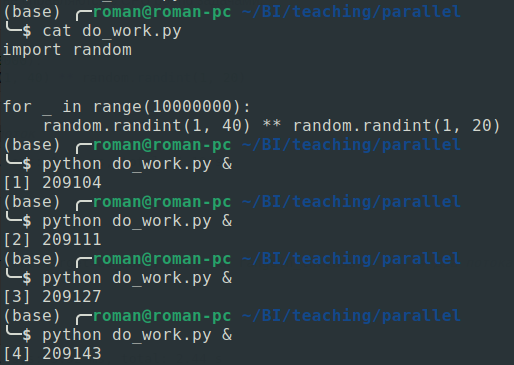 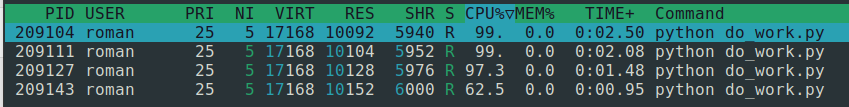

**Ещё одно важное замечание**. Питон всего лишь создаёт новые процессы, но ОС уже решает на каких ядрах CPU эти процессы будут выполняться, питон уже не может это контролировать

### 2 процесса мало, хочу ещё больше

In [34]:
%%time
n_proc = 4

procs = [multiprocessing.Process(target=do_work) for _ in range(n_proc)]
for proc in procs:
    proc.start()
for proc in procs:
    proc.join()     

CPU times: user 4.05 ms, sys: 12 ms, total: 16.1 ms
Wall time: 1.1 s


И мы успешно выполнили параллельно 4 функции `do_work` за тоже самое время

### 8 процессов

In [35]:
%%time
n_proc = 8

procs = [multiprocessing.Process(target=do_work) for _ in range(n_proc)]
for proc in procs:
    proc.start()
for proc in procs:
    proc.join()     

CPU times: user 3.1 ms, sys: 33 ms, total: 36.1 ms
Wall time: 1.14 s


### 12 процессов

In [36]:
%%time
n_proc = 12

procs = [multiprocessing.Process(target=do_work) for _ in range(n_proc)]
for proc in procs:
    proc.start()
for proc in procs:
    proc.join()     

CPU times: user 2.12 ms, sys: 39.5 ms, total: 41.6 ms
Wall time: 1.38 s


Невероятно круто! Мы смогли параллельно запустить целых 12 функций `do_work` и они всё ещё занимают столько же времени, сколько и одна. Последовательно же 12 функций выполнялись бы долго... 

In [37]:
%%time

for _ in range(12):
    do_work()

CPU times: user 12.7 s, sys: 9.39 ms, total: 12.8 s
Wall time: 12.8 s


### Отлично, как насчёт 36 процессов?

In [38]:
%%time
n_proc = 36

procs = [multiprocessing.Process(target=do_work) for _ in range(n_proc)]
for proc in procs:
    proc.start()
for proc in procs:
    proc.join()     

CPU times: user 11.2 ms, sys: 78.3 ms, total: 89.5 ms
Wall time: 3.28 s


### И время почему-то увеличилось более чем в 2 раза...

Почему так произошло? Всё дело в количестве ядер, поскольку я имею 12 ядер, это позволяет мне исполнять только 12 потоков по настоящему **параллельно**. В случае с CPU bound задачами не прокатывает фишка с быстрым переключением потоков, так как процессор не простаивает ни секунды, а значит выгоды получить не удастся.

Но а как же Simultaneous Multithreading, он же даёт нам ещё одно логическое ядро, которое помогает ускорить выполнение?

Ответ прост: поскольку мы выполняем однотипные задачи, то свободные ресурсы процессора нам не особо актуальны. Мы хотим умножать, но умножающий модуль занят, придётся ждать. А вот в распараллеливании разноплановых задач Simultaneous Multithreading проявляет себя получше. Тем не менее небольшого ускорения он всё-таки позволяет добиться, поэтому время и не увеличилось ровно в 3 раза.

Эту интересную особенность (резкий скачок времени выполнения при превышении количеством процессов количества ядер) можно использовать весьма необычно. Давайте определим количество ядер в компьютере по графику зависимости времени выполнения от количества ядер.

Попробуйте разобраться в коде для построения графика самостоятельно

In [57]:
from tqdm.notebook import tqdm
import multiprocessing

In [59]:
def do_work_in_parallel(n_workers):
    start = time.time()
    procs = [multiprocessing.Process(target=do_work) for _ in range(n_workers)]
    for proc in procs:
        proc.start()
    for proc in procs:
        proc.join()
    return time.time() - start


core_times = []
for n_cores in tqdm(range(1, 41)):
    time_to_work = do_work_in_parallel(n_cores)
    core_times.append(time_to_work)

  0%|          | 0/40 [00:00<?, ?it/s]

Process Process-2:
Traceback (most recent call last):
  File "/home/paul-valery/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/paul-valery/miniconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_19869/1470424406.py", line 6, in do_work
    random.randint(1, 40) ** random.randint(1, 20)
  File "/home/paul-valery/miniconda3/lib/python3.9/random.py", line 338, in randint
    return self.randrange(a, b+1)
  File "/home/paul-valery/miniconda3/lib/python3.9/random.py", line 314, in randrange
    return istart + self._randbelow(width)
  File "/home/paul-valery/miniconda3/lib/python3.9/random.py", line 237, in _randbelow_with_getrandbits
    def _randbelow_with_getrandbits(self, n):
KeyboardInterrupt


KeyboardInterrupt: 

In [60]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Время выполнения, с')

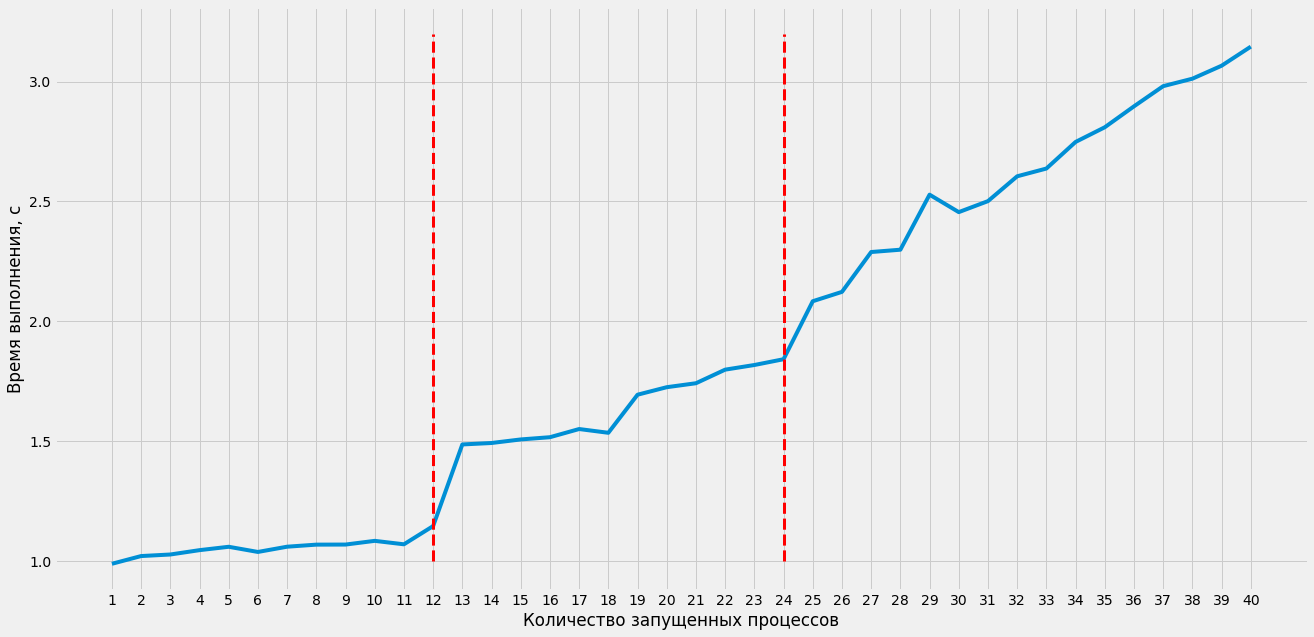

In [54]:
plt.rc("figure", figsize=(20, 10))
plt.rc("font", size=20)
plt.style.use("fivethirtyeight")

plt.plot(range(1, 41), core_times)
plt.xticks(range(1, 41), range(1, 41))
plt.vlines([12, 24], 1, 3.2, color="red", lw=3, linestyle="dashed")
plt.xlabel("Количество запущенных процессов")
plt.ylabel("Время выполнения, с")

На первый взгляд, мы видим самый обычный график. Однако, обратите внимание на его самое начало. Время выполнения очень слабо увеличивается в ответ на увеличение числа процессов. Это значит, что мы ещё не превысили количество ядер CPU. Небольшое увеличение времени связано с тем, что на создание процессов тоже требуется время и, чем их больше, тем больше его нужно.

Обратим внимание на точку, где происходит резкий скачок по времени. Это точка 13. Увеличение времени связано с тем, что при запуске 13-го процесса все ядра уже заняты, поэтому он не попадает на ядро и ему приходится ждать пока хотя бы одно не освободится. То есть, грубо говоря, у нас выполнились 12 процессов параллельно и один последовательно после них. Это значит, что предыдущая точка до скачка (12) означает количество ядер у нас. Можете проверить это у себя на компьютере, если не уверены, сколько у вас ядер.

Но и это ещё не всё. Далее мы видим ещё один скачок на уровне 25 процессов, который делит оставшийся график на 2 части. Время на интервале с 13 по 24 процесса увеличивается, но не так быстро как на интервале 25-40. Это связано с тем, что когда мы заполнили все ядра, начинают работать логические ядра (благодаря Simultaneous Multithreading). Хоть они и не очень эффективны в однотипных задачах, но всё же немного ускоряют работу. Как раз поэтому время на интервале 13-24 увеличивается медленнее. После загрузки всех логических ядер происходит ещё один скачок, после которого время начинает увеличиваться более резко.

## Доступ к данным

У потоков было всё очень хорошо и прозрачно в отношении доступа к данным. А что с процессами? Тут всё очень просто, его нет)))

Попробуем провернуть тот же фокус с добавлением элементов в список как в случае с `threading`. Создадим три процесса, которые будут добавлять числа в список, находящийся в глобальном окружении.

In [61]:
lst = []

def append_to_list(pid):
    time.sleep(random.randint(1, 5))
    lst.append(pid)
    print(lst)

procs = [multiprocessing.Process(target=append_to_list, args=(i,)) for i in range(3)]
for proc in procs:
    proc.start()
for proc in procs:
    proc.join()

[1]

[2][0]


In [62]:
lst

[]

Список пустой, но и ошибки никакой не произошло. Куда же добавляли элементы процессы? Выведем содержимое `lst` внутри процессов, предварительно заполнив его.

In [63]:
lst = ["P", "r", "o", "c", "e", "s", "s"]

def append_to_list(pid):
    time.sleep(random.randint(1, 5))
    lst.append(pid)
    print(f"Process: {pid}, lst = {lst}")

procs = [multiprocessing.Process(target=append_to_list, args=(i,)) for i in range(3)]
for proc in procs:
    proc.start()
for proc in procs:
    proc.join()

Process: 1, lst = ['P', 'r', 'o', 'c', 'e', 's', 's', 1]
Process: 2, lst = ['P', 'r', 'o', 'c', 'e', 's', 's', 2]
Process: 0, lst = ['P', 'r', 'o', 'c', 'e', 's', 's', 0]


In [64]:
lst

['P', 'r', 'o', 'c', 'e', 's', 's']

Очень страннно... Оказывается, что каждый процесс сохраняет себе собственную копию `lst` и добавляет в него число. `lst` же в главном процессе остаётся без изменений. Такое поведение происходит из самого механизма создания процессов в операционной системе.

Создание процесса происходит с помощью системного вызова **fork()**. Системный вызов это специальная функция, которую использует операционная система для своей работы. При этом происходит создание **полной копии процесса**, в котором fork был вызван. Начальный процесс теперь является **родителем**, а новый процесс **потомком**. Изначально они являются полностью одинаковыми, но потомки вскоре начинают изменяться в зависимости от нужд. При завершении родительского процесса автоматически завершаются все его потомки.

Когда мы пользуемся модулем `multiprocessing` мы своими глазами не видим вызова **fork**, но он происходит внутри, в тот момент, когда мы вызываем метод `start`.

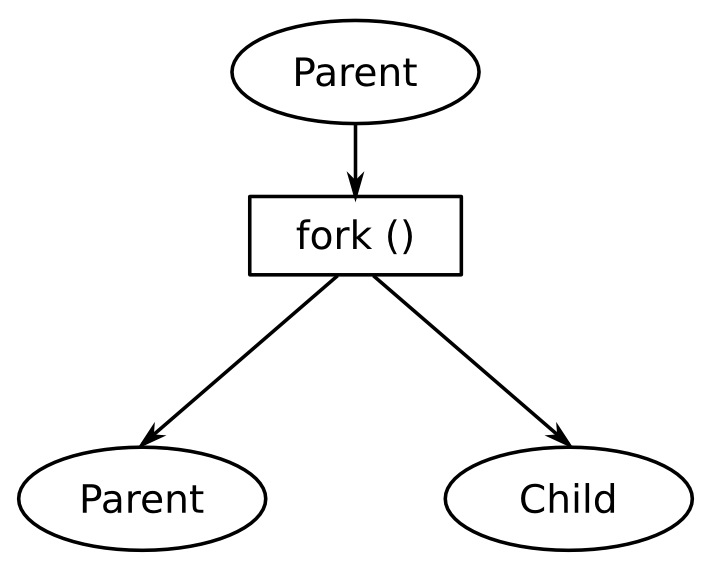

В нашем случае при создании процесса он стал полной копией процесса-родителя, а значит сохранил ВСЕ переменные объявленные в нём, в том числе и `lst`. После этого события память процессов становится изолированной друг от друга, а значит и обмен данными невозможен (почти).

### Получение данных из процесса

Скорее всего, вы будете создавать различные процессы, чтобы распараллелить расчёты. Но там где есть расчёты, есть и результаты, которые мы хотим получить. В таком случае появляется вопрос, как получить данные из процесса? Мы ведь уже выяснили, что они имеют полностью изолированную память, а значит придётся как-то ухищряться

Для обмена данными между процессами нам нужно **что-то**, что способно обеспечить безопасный доступ к данным, вариантов тут может быть несколько

#### Файлы

Суть подхода такова:
1. Процессы сохраняют результаты расчётов на диск
2. После завершения всех процессов, мы загружаем все файлы и собираем все результаты в главном процессе
3. Обрабатываем результаты

Рассмотрим на примере, допустим, что наши процессы делают какие-то сложные операции с датафреймами

In [65]:
import numpy as np
import pandas as pd

In [15]:
dataframes = [pd.DataFrame(np.random.uniform(size=(10, 10))) for _ in range(10)]

def do_math(df, process_id):
    # Очень сложная и вычислительно объёмная математика
    result = df
    result.to_csv(f"result_{process_id}.csv")

processes = [multiprocessing.Process(target=do_math, args=(df, pid))
             for pid, df in enumerate(dataframes)]
for proc in processes:
    proc.start()
for proc in processes:
    proc.join()
    

results = [pd.read_csv(f"result_{process_id}.csv") for process_id, _ in enumerate(dataframes)]

В коде выше мы сделали процессы, каждый из которых обрабатывает один датафрейм и сохраняет результат в CSV файл. После завершения всех процессов мы можем считать эти файлы обратно в питон, так как мы знаем логику их названий

Этот вариант довольно некрасивый, но тем не менее рабочий. Для сохранения на диск произвольных питоновских объектов (например, списков) можно воспользоваться модулем `pickle` (его мы здесь обсуждать не будем)

#### `ProcessPoolExecutor`

Аналогично `ThreadPoolExecutor` этот объект уммеет возвращать для нас данные из процессов

In [73]:

dataframes = [pd.DataFrame(np.random.uniform(size=(10, 10))) for _ in range(10)]

def do_math(df):
    # Очень сложная и вычислительно объёмная математика
    result = df
    return result

with ProcessPoolExecutor(10) as pool:
    results = list(pool.map(do_math, dataframes))

AttributeError: module 'multiprocessing' has no attribute 'ProcessPoolExecutor'

Работает! Результаты возвращаются из процессов, очень удобно. Но вы же не подумали, что всё ТАК просто? У `ProcessPoolExecutor` имеется огромный подводный камень

Допустим, что у нас есть какой-то класс, который занимается вычислениями

In [22]:
class Calculator:
    def generate_dataframes(self, n):
        return [pd.DataFrame(np.random.uniform(size=(10, 10))) for _ in range(n)]
    
    def process_multiple_dataframes(self, dataframes, n_jobs=1):
        def process_single_dataframe(df):
            # Очень сложная и вычислительно объёмная математика
            result = df
            return result
    
        with ProcessPoolExecutor(n_jobs) as pool:
            results = list(pool.map(process_single_dataframe, dataframes))
        return results

Здесь мы просто переписали код из предыдущего примера в виде класса. У нас есть метод для генерации даных и есть метод, который выполняет расчёты для нескольких датафреймов параллельно. В последнем из них используется функция, объявленная в этом же методе. На самом деле, это довольно стандартная практика. Часто бывает так, что мы не хотим засорять интерфейс нашего класса всякими вспомогательными методами, поэтому объявить `target` функцию для распараллеливания часто бывает полезно прямо в том месте, где её нужно использовать, в таком случае она не будет видна внешним пользователям 

In [24]:
calculator = Calculator()
data = calculator.generate_dataframes(10)
calculator.process_multiple_dataframes(data, n_jobs=10)

AttributeError: Can't pickle local object 'Calculator.process_multiple_dataframes.<locals>.process_single_dataframe'

Ошибочка! Дело в том, что `ProcessPoolExecutor` не умеет работать с подобными функциями, объявленными внутри других функций, только с глобальными или с методами класса.

Кстати, `ProcessPoolExecutor` у себя под капотом также выполняет что-то похожее на сохранение на диск

#### Специальные типы данных

Модуль `multiprocessing` также предоставляет доступ к специальным типам данных, которые можно использовать для общения между процессами. Эти типы данных реализованы так, что они являются защищёнными от одновременного доступа, поэтому они могут быть общими для многих процессов

+ [Специальные типы данных](https://docs.python.org/3/library/multiprocessing.html#module-multiprocessing.sharedctypes), позволяющие изменять их из другого процесса
+ [Пайпы](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.Pipe) (говоря очень упрощённо, это файлы через которые происходит общение между процессами посредством записи/чтения оттуда)
+ [Очереди](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.Queue) (привычные вам очереди, но адаптированые для использования с многопроцессорностью, по своей сути являются просто высокоуровневой надстройкой над пайпами)

#### Итог по получению данных из процесса

Чётких рекомендаций тут нет, выбирать нужно исключительно оглядываясь на ваши личные предпочтения и задачу. Нет ничего такого в том, чтобы использовать файлы и, иногда, лишним может быть городить огород со пайпами и очередями. Используйте то, что вам нравится или более удобно

## Итоги по multiprocessing

**Когда стоит использовать:**
+ Любые CPU bound задачи
+ I/O bound задачи, но с поправкой на то, что создавать процессы гораздо более накладно в плане занимаемой ими памяти.

**Плюсы:**
+ Настоящая параллельность на разных ядрах CPU
+ Максимально безопасны в отношении доступа к памяти

**Минусы:**
+ Тяжеловесны
+ Один процесс - одно ядро. Если у нас мало ядер, то очень большое ускорение получить не выйдет.
+ Нельзя пользоваться общей памятью, если не хочешь вставать на костыли

**Примечание:** Самый частый use-case - распараллеливание вычислений. Если нам нужно обрабатывать какие-то большие таблицы, картинки или что-то ещё. Для этого мы обязательно берём **multiprocessing**, большинство вычислений это CPU bound. Возвращаемся наверх к 3 способам **multiprocessinga** и выбираем любой понравившийся

# Итоги

В каждом разделе мы уже проговорили более чем достаточно для общего понимания происходящего. Всё это только верхушка айсберга и в каждой из рассмотренных библиотек есть низкоуровневые функции, которые позволяют с головой закопаться в то, как это всё работает.

Зачастую, для любых задач с головой хватает **multiprocessing** (для CPU bound) и **threading** (для IO bound).

#### Бонусный ребус

In [25]:
def target_func():
    import threading
    
processes = [multiprocessing.Process(target=target_func) for _ in range(10)]
for proc in processes:
    proc.start()